# pnCCD tests

Looking at data acquired at pnSensors in Feb. 2023 using an 57Fe source.

Only files in bold are considered here :

- **CXC_230220_001.txt**
- CXC_230220_001_0001.frms6
- CXC_230220_001_0002.frms6
- CXC_230220_001_DarkCalibrationFrames.frms6
- CXC_230220_001_GainArray.npz
- **CXC_230220_001__Calc_1_1.raw**
- **CXC_230220_001__FinalCube.raw**

In [1]:
configFile = "CXC_230220_001.txt"  # configuration file
finalFile = "CXC_230220_001__FinalCube.raw"  # standard data cube considering 1-4 pixel events integration
calc1_1File = "CXC_230220_001__Calc_1_1.raw"  # data cube considering only single pixel events

# Imports and Defs

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from lmfit.models import GaussianModel

%matplotlib notebook

def read_config(filename):
    config = {}
    with open(filename) as f:
        for line in f:
            (key, val) = line.split()
            config[key.replace(":","")] = val
    return config

def read_raw(filename, ecal, binsize):
    data = np.fromfile(filename,dtype='uint16')
    data = data.reshape(264,264,-1)
    energy = np.arange(data.shape[-1])*ecal*binsize
    return data, energy

# Read the data

In [3]:
config = read_config(configFile)
print(f"Reading acquisition configuration from {configFile}")
for key in config.keys():
    print(f"{key} : {config[key]}")

Reading acquisition configuration from CXC_230220_001.txt
DATETIME : 2023-02-20_14-55-22
TIMING : 1000Hz
GAINVAL : max:4
MODE : FullFrame
ENRGCAL : 2.0711014973171893
NUMFRMS : 40000
EVSZMIN : 1
EVSZMAX : 4
NUMBINS : 2000
BINSIZEADU : 10
COMMENT : comment


In [4]:
ecal = float(config["ENRGCAL"])
print( f"Energy calibration : {ecal} eV/channel")

binsize = float(config["BINSIZEADU"])
print( f"Post acquisition bin size : {binsize} channels")

Energy calibration : 2.0711014973171893 eV/channel
Post acquisition bin size : 10.0 channels


In [5]:
# "standard" data cube (events of 1 to 4 pixel are counted)
dFinal, eFinal = read_raw(filename=finalFile, ecal=ecal, binsize=binsize)

# "single pixel event" data cube (events of only 1 pixel are counted)
d1_1, e1_1 = read_raw(filename=calc1_1File, ecal=ecal, binsize=binsize)


# Data visualization for the "standard" case (1-4 pixel events)

## Pixel-mean (*i.e.* single energy spectrum)

<IPython.core.display.Javascript object>


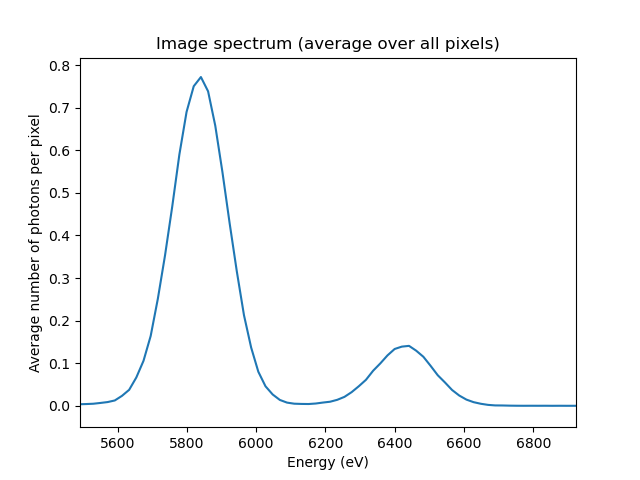

In [6]:
fig,ax = plt.subplots()
ax.plot(eFinal,dFinal.mean(axis=(0,1)))

## plot Mn lines
#linesMn = [5898.75,5887.65,6490.45] 
#ax.vlines(linesMn,0,3,color='k')

## plot random pixels
#for iii in np.arange(1):
#    ix,iy = np.random.randint(264),np.random.randint(264)
#    ax.plot(np.arange(2000)*ecal*10,d[ix,iy,:])

ax.set_xlabel("Energy (eV)")
ax.set_ylabel("Average number of photons per pixel")
ax.set_title("Image spectrum (average over all pixels)")

plt.show()

The signal is dominated by counts in the lower channels (< 125 eV, *i.e.* < channel #62)

## CCD mode (integration of all channels for each pixel)

<IPython.core.display.Javascript object>


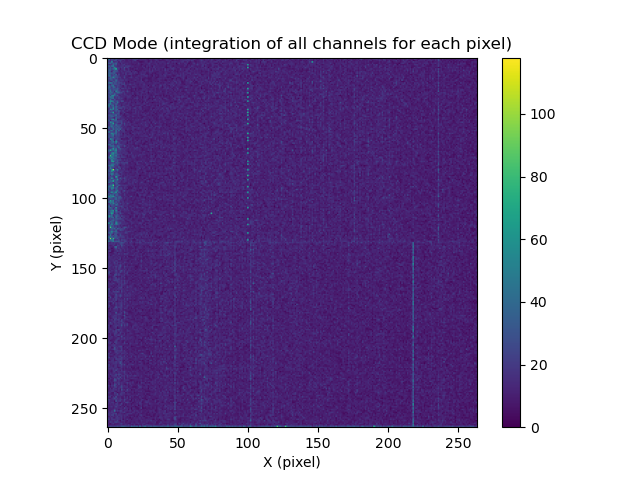

In [7]:
fig,ax = plt.subplots()
im = ax.imshow(dFinal.sum(axis=-1))
plt.colorbar(im)
ax.set_xlabel("X (pixel)")
ax.set_ylabel("Y (pixel)")
ax.set_title("CCD Mode (integration of all channels for each pixel)")
plt.show()

The signal in the lower channels (< 125 eV, *i.e.* < channel #62) may be different from pixel to pixel ?

Let us not consider them.

## Pixel-mean (*i.e.* single energy spectrum), ignoring lower channels

<IPython.core.display.Javascript object>


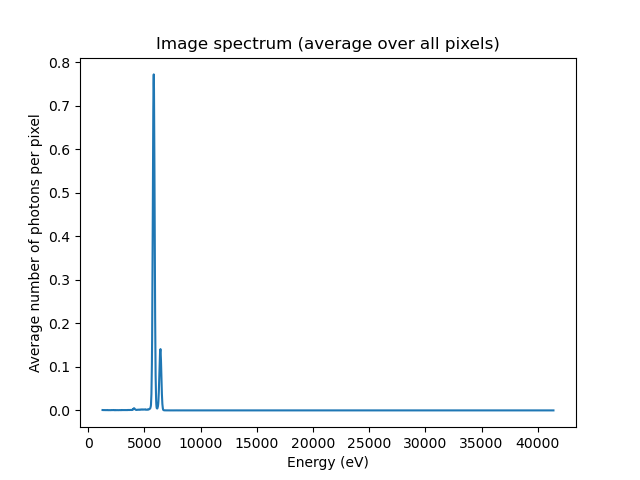

In [8]:
channelMin = 62
fig,ax = plt.subplots()
ax.plot(eFinal[channelMin:],dFinal.mean(axis=(0,1))[channelMin:])

ax.set_xlabel("Energy (eV)")
ax.set_ylabel("Average number of photons per pixel")
ax.set_title("Image spectrum (average over all pixels)")

plt.show()

## CCD mode (integration of higher channels for each pixel)

<IPython.core.display.Javascript object>


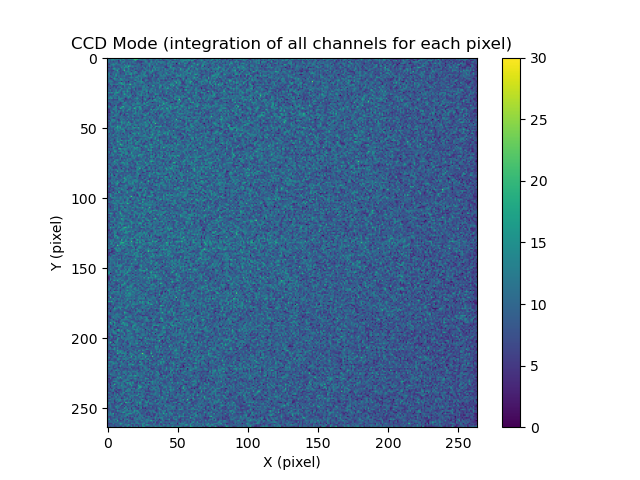

In [9]:
fig,ax = plt.subplots()
im = ax.imshow(dFinal[:,:,channelMin:].sum(axis=-1))
plt.colorbar(im)
ax.set_xlabel("X (pixel)")
ax.set_ylabel("Y (pixel)")
ax.set_title("CCD Mode (integration of all channels for each pixel)")
plt.show()

Much better, homogeneous illumination...

# Data visualization for the single pixel events

Hopefully the best energy resolution

<IPython.core.display.Javascript object>


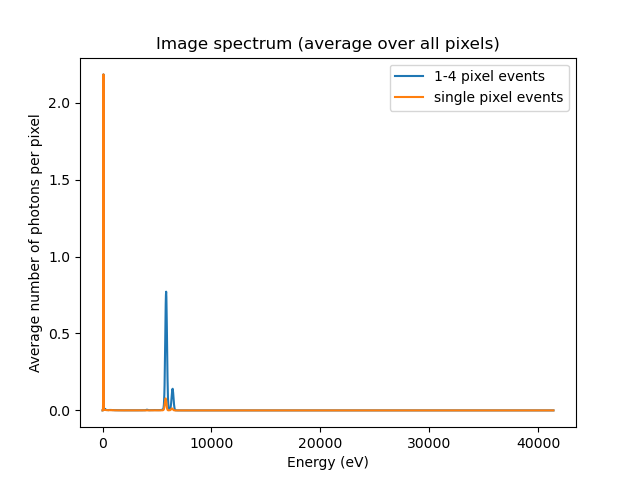

In [10]:
fig,ax = plt.subplots()
ax.plot(eFinal,dFinal.mean(axis=(0,1)), label="1-4 pixel events")
ax.plot(e1_1,d1_1.mean(axis=(0,1)), label="single pixel events")
plt.legend()
ax.set_xlabel("Energy (eV)")
ax.set_ylabel("Average number of photons per pixel")
ax.set_title("Image spectrum (average over all pixels)")

plt.show()


## zoom in

<IPython.core.display.Javascript object>


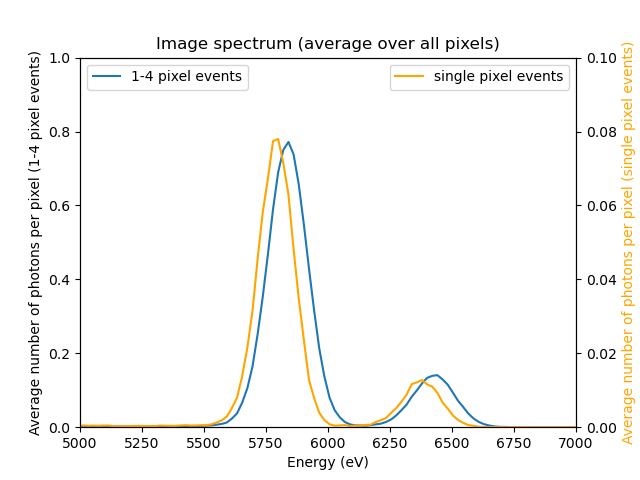

In [11]:
fig,ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(eFinal,dFinal.mean(axis=(0,1)), label="1-4 pixel events")
ax2.plot(e1_1,d1_1.mean(axis=(0,1)), label="single pixel events", color="orange")
ax.legend(loc=2)
ax2.legend(loc=0)
ax.set_xlabel("Energy (eV)")
ax.set_ylabel("Average number of photons per pixel (1-4 pixel events)")
ax2.set_ylabel("Average number of photons per pixel (single pixel events)", color="orange")
ax.set_title("Image spectrum (average over all pixels)")
ax.set_xlim(5000,7000)
ax.set_ylim(0,1)
ax2.set_ylim(0,0.10)

plt.show()

The "single-pixel events only" shows slightly narrower peaks, as expected. The counting rate is about 10x lower (a expected) and the energy calibration seems different

## Fitting the peak

In [44]:
def fit_peak(x,y):
    model = GaussianModel()
    params = model.guess(y, x=x)
    result = model.fit(y, params, x=x)
    print(result.fit_report())
    fig,ax = plt.subplots()
    result.plot_fit()
    return result

### "1-4 pixels events"

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 36
    # variables        = 3
    chi-square         = 4.9813e-04
    reduced chi-square = 1.5095e-05
    Akaike info crit   = -396.774011
    Bayesian info crit = -392.023454
[[Variables]]
    amplitude:  154.925660 +/- 0.36548029 (0.24%) (init = 191.2987)
    center:     5836.72438 +/- 0.21887137 (0.00%) (init = 5840.506)
    sigma:      80.3498074 +/- 0.21888070 (0.27%) (init = 82.84406)
    fwhm:       189.209333 +/- 0.51542465 (0.27%) == '2.3548200*sigma'
    height:     0.76921652 +/- 0.00181463 (0.24%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


<IPython.core.display.Javascript object>


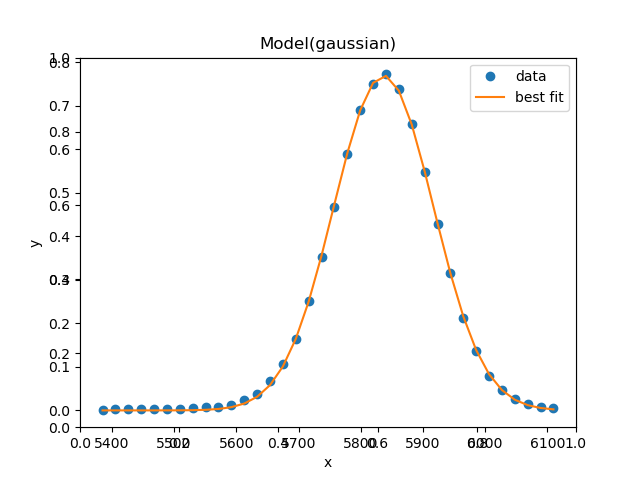

In [45]:
chanMin, chanMax = 260,295
x = eFinal[chanMin:chanMax+1]
y = dFinal[:,:,chanMin:chanMax+1].mean(axis=(0,1))
resultFinal = fit_peak(x,y)

### "1 pixel events"

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 36
    # variables        = 3
    chi-square         = 2.5290e-05
    reduced chi-square = 7.6636e-07
    Akaike info crit   = -504.070365
    Bayesian info crit = -499.319808
[[Variables]]
    amplitude:  14.0333576 +/- 0.07802555 (0.56%) (init = 16.88966)
    center:     5791.21143 +/- 0.46311093 (0.01%) (init = 5788.729)
    sigma:      72.1338848 +/- 0.46311093 (0.64%) (init = 72.48855)
    fwhm:       169.862315 +/- 1.09054289 (0.64%) == '2.3548200*sigma'
    height:     0.07761262 +/- 4.3153e-04 (0.56%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


<IPython.core.display.Javascript object>


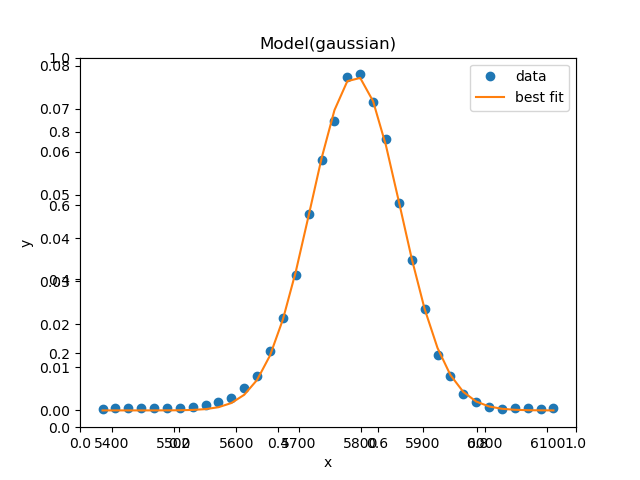

In [46]:
chanMin, chanMax = 260,295
x = e1_1[chanMin:chanMax+1]
y = d1_1[:,:,chanMin:chanMax+1].mean(axis=(0,1))
result1_1 = fit_peak(x,y)

## CCD mode (integration of higher channels for each pixel)

<IPython.core.display.Javascript object>


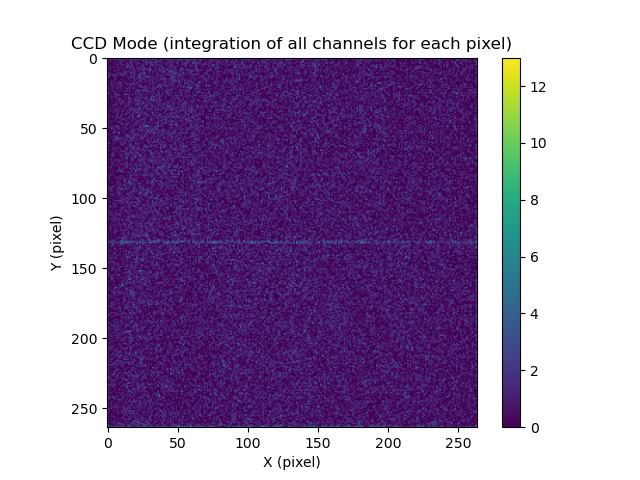

In [12]:
fig,ax = plt.subplots()
im = ax.imshow(d1_1[:,:,channelMin:].sum(axis=-1))
plt.colorbar(im)
ax.set_xlabel("X (pixel)")
ax.set_ylabel("Y (pixel)")
ax.set_title("CCD Mode (integration of all channels for each pixel)")
plt.show()

In single-pixel events counting, the middle line seems to count more than the rest

<IPython.core.display.Javascript object>


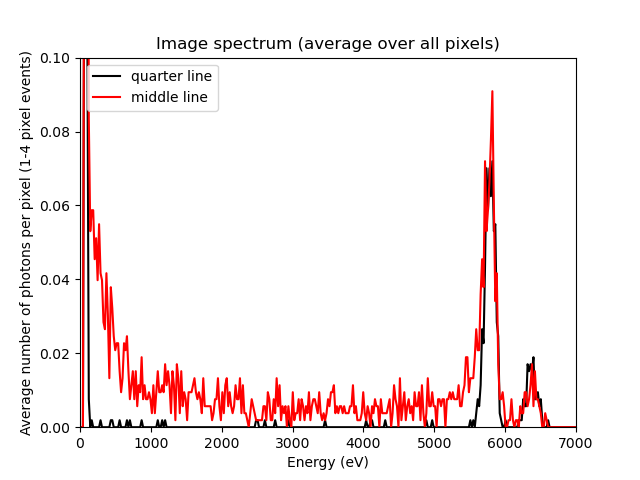

In [13]:
fig,ax = plt.subplots()
ax.plot(e1_1,d1_1[61:63,:,:].mean(axis=(0,1)), label="quarter line", color="k")
ax.plot(e1_1,d1_1[131:133,:,:].mean(axis=(0,1)), label="middle line", color="r")

ax.legend(loc=2)
ax.set_xlabel("Energy (eV)")
ax.set_ylabel("Average number of photons per pixel (1-4 pixel events)")
ax.set_title("Image spectrum (average over all pixels)")
ax.set_xlim(0,7000)
ax.set_ylim(0,0.1)

plt.show()

In single-pixel events counting, there is more noise in the middle line 